# NLP Project

Project done by Jimy Salem & Yazid Ben Madani

## Importing Necessary Libraries & Definining Needed Functions

In [1]:
!pip install --upgrade tensorflow tensorflow-hub
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Bidirectional, LSTM, GRU, Embedding
import tensorflow_datasets as tfds
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns

path_train=r'/kaggle/input/nlp-project-dataset/train.txt'
path_test=r'/kaggle/input/nlp-project-dataset/test.txt'

colnames=['text', 'sentiment']
train_df=pd.read_csv(path_train, delimiter=';', names=colnames)
test_df=pd.read_csv(path_test, delimiter=';', names=colnames)

train_df.head()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 56.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 65.4 MB/s eta 0:00:00
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 23.5.26
    Uninstalling flatbuffers-23.5.26:
      Successfully uninstalled flatbuffers-23.5.26
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: keras
    Found existing installation: keras 3.3.3
    Uninstalling keras-3.3.3:
      Successfully uninstalled keras-3.3.3
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.15.0
    Uninstalling tensorflow-2.15.0:
      Successfully uninstalled tensorflow-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that ar

2024-07-15 09:55:31.528514: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-15 09:55:31.528578: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-15 09:55:31.530125: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


,text,sentiment
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [2]:
print("TensorFlow version:", tf.__version__)
print("TensorFlow Hub version:", hub.__version__)

TensorFlow version: 2.15.1
TensorFlow Hub version: 0.16.1


In [3]:
test_df.head()

,text,sentiment
0,im feeling rather rotten so im not very ambiti...,sadness
1,im updating my blog because i feel shitty,sadness
2,i never make her separate from me because i do...,sadness
3,i left with my bouquet of red and yellow tulip...,joy
4,i was feeling a little vain when i did this one,sadness


In [4]:
train_df['sentiment'].unique()

array(['sadness', 'anger', 'love', 'surprise', 'fear', 'joy'],
      dtype=object)

In [5]:
train_df.shape

(16000, 2)

In [6]:
def plot_results(history):
    hist_df = pd.DataFrame(history.history)
    hist_df.columns=["loss", "accuracy", "val_loss", "val_accuracy"]
    hist_df.index = np.arange(1, len(hist_df)+1)

    fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(16, 10))
    axs[0].plot(hist_df.val_accuracy, lw=3, label='Validation Accuracy')
    axs[0].plot(hist_df.accuracy, lw=3, label='Training Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].grid()
    axs[0].legend(loc=0)
    axs[1].plot(hist_df.val_loss, lw=3, label='Validation Loss')
    axs[1].plot(hist_df.loss, lw=3, label='Training Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].grid()
    axs[1].legend(loc=0)

    plt.show();
    
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    accuracy = accuracy_score(y_test, y_pred_classes)
    precision = precision_score(y_test, y_pred_classes, average='weighted')
    recall = recall_score(y_test, y_pred_classes, average='weighted')
    f1 = f1_score(y_test, y_pred_classes, average='weighted')
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    plot_confusion_matrix(y_test, y_pred_classes, classes=le.classes_)
    


In [7]:
le = LabelEncoder()
train_df['sentiment'] = le.fit_transform(train_df['sentiment'])
test_df['sentiment'] = le.fit_transform(test_df['sentiment'])

print(train_df['sentiment'].unique())

[4 0 3 5 1 2]


In [8]:
number_used=5000 #for lowering computations
train_text = train_df['text'].values [:number_used]
train_labels = train_df['sentiment'].values[:number_used]
test_text = test_df['text'].values[:number_used]
test_labels = test_df['sentiment'].values[:number_used]

X_train, X_val, y_train, y_val = train_test_split(train_text, train_labels, test_size=0.2, random_state=42, shuffle=True)

## Models

##### Ensuring GPU being used

In [9]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(f"{len(gpus)} Physical GPUs, {len(logical_gpus)} Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


### Model 1 - Fully Connected Neural Network

In [10]:
embed1 = "https://tfhub.dev/google/nnlm-en-dim50/2"
num_epochs=50
num_classes=len(train_df['sentiment'].unique())

In [11]:
model1 = tf.keras.models.Sequential([
    hub.KerasLayer(embed1, input_shape=[], dtype=tf.string, trainable=True),
    Dense(128, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    BatchNormalization(),
    Dropout(rate=0.6),
    Dense(300, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    BatchNormalization(),
    Dropout(rate=0.6),
    Dense(len(np.unique(y_train)), activation="softmax")
])

model1.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stopping1 = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history1 = model1.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), callbacks=[early_stopping1])


Epoch 1/50


I0000 00:00:1721037353.232978     116 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


125/125 [==============================] - 19s 112ms/step - loss: 4.7512 - accuracy: 0.2697 - val_loss: 3.6943 - val_accuracy: 0.4260
Epoch 2/50
125/125 [==============================] - 6s 47ms/step - loss: 3.8462 - accuracy: 0.4010 - val_loss: 3.3076 - val_accuracy: 0.4850
Epoch 3/50
125/125 [==============================] - 3s 26ms/step - loss: 3.2755 - accuracy: 0.4560 - val_loss: 2.9159 - val_accuracy: 0.5370
Epoch 4/50
125/125 [==============================] - 3s 21ms/step - loss: 2.7426 - accuracy: 0.5418 - val_loss: 2.5571 - val_accuracy: 0.5540
Epoch 5/50
125/125 [==============================] - 3s 22ms/step - loss: 2.3423 - accuracy: 0.5935 - val_loss: 2.2550 - val_accuracy: 0.5970
Epoch 6/50
125/125 [==============================] - 2s 17ms/step - loss: 1.9514 - accuracy: 0.6733 - val_loss: 2.0108 - val_accuracy: 0.6360
Epoch 7/50
125/125 [==============================] - 2s 16ms/step - loss: 1.6022 - accuracy: 0.7405 - val_loss: 1.8105 - val_accuracy: 0.6720
Epoch 8/

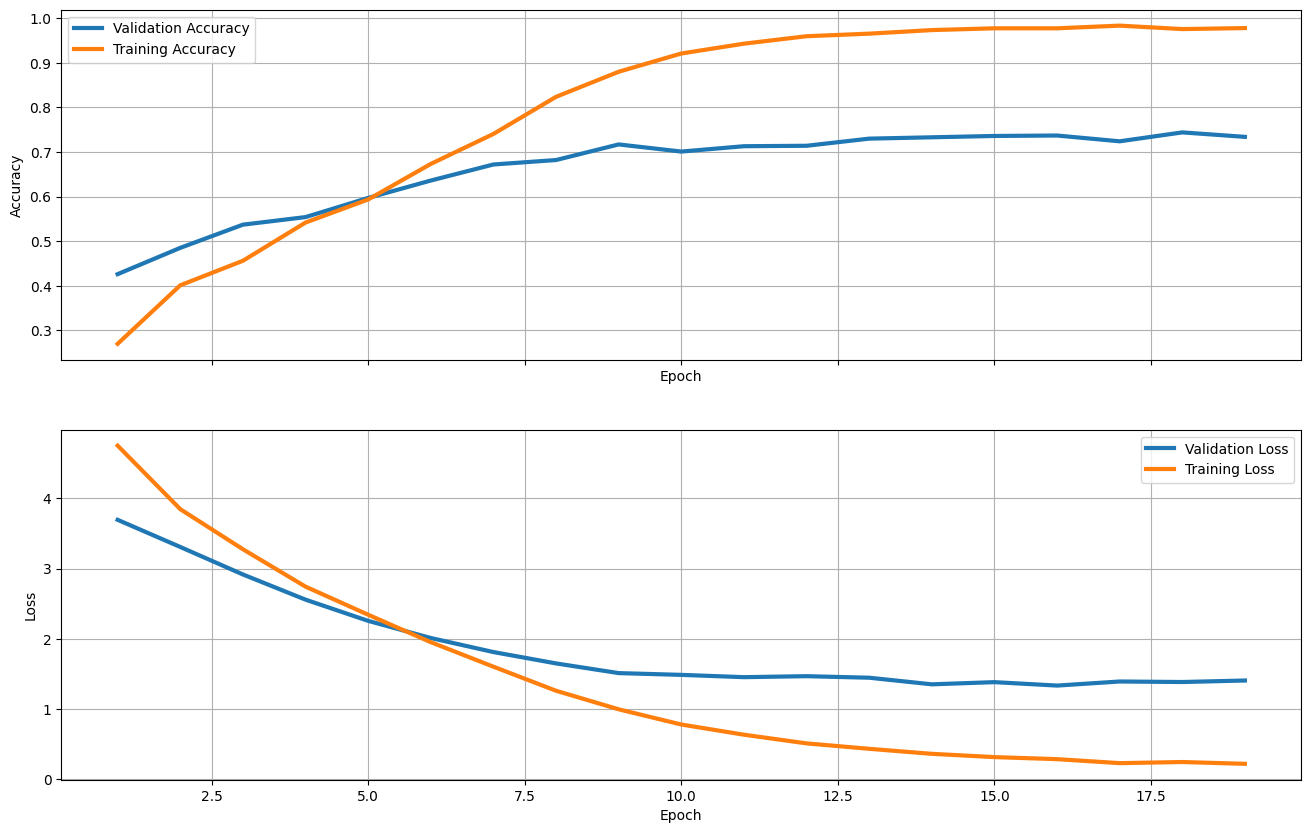

In [12]:
plot_results(history1)

63/63 [==============================] - 0s 3ms/step
Accuracy: 0.7485
Precision: 0.7503
Recall: 0.7485
F1 Score: 0.7471


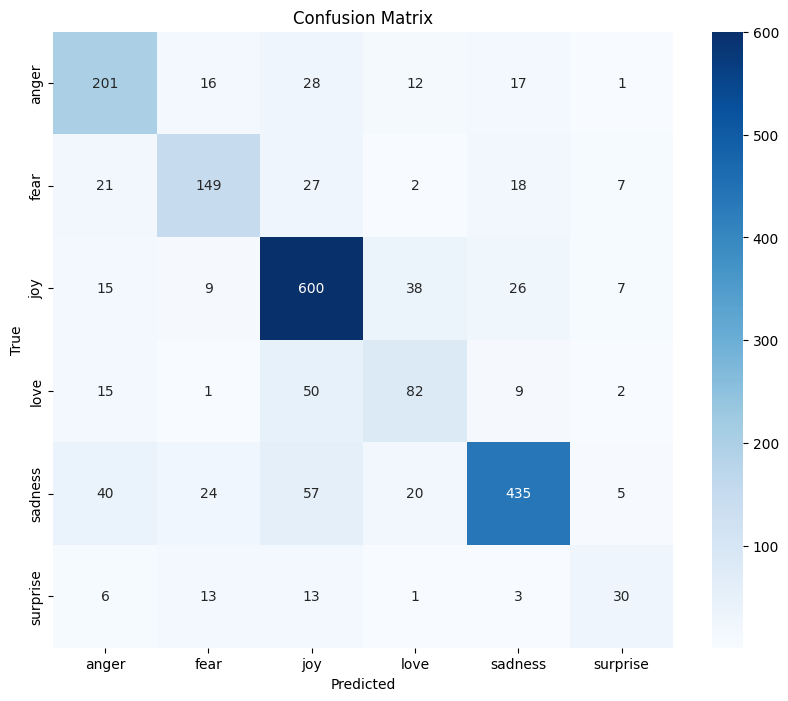

In [13]:
evaluate_model(model1, test_text, test_labels)

Many modelshave been previously tried but resuled to overfitting, however this model of fully connected layer seems more promising

### Model 2 - RNN with LSTM/GRU

#### Creating padding & Sequence

In [14]:
vocab_size = 10000
embedding_dim = 16
max_length = 120
trunc_type='post'
oov_tok = "<OOV>"

number_new = 10000
# turn it to numpy array and take number used to lower computations
train_text = train_df['text'].values [:number_new]
train_labels = train_df['sentiment'].values[:number_new]
test_text = test_df['text'].values[:number_new]
test_labels = test_df['sentiment'].values[:number_new]

X_train, X_val, y_train, y_val = train_test_split(train_text, train_labels, test_size=0.2, random_state=42)

In [15]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)

train_sequence=tokenizer.texts_to_sequences(X_train)
train_padded=pad_sequences(train_sequence,maxlen=max_length, truncating=trunc_type)

test_sequences=tokenizer.texts_to_sequences(X_val)
test_padded=pad_sequences(test_sequences,maxlen=max_length)

In [16]:
train_sequence[10]

[2, 64, 5, 46, 4, 3, 244, 219, 129, 173, 2715]

#### GRU Model

In [17]:
model2 = tf.keras.Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    Bidirectional(GRU(32)),
    Dense(6, activation='relu'),
    Dense(num_classes, activation='softmax')
])
model2.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

history2 = model2.fit(train_padded, y_train, epochs=num_epochs, validation_data=(test_padded, y_val))

#loss, accuracy = model2.evaluate(test_padded, y_val)
# print(f'Loss: {loss}')
# print(f'Accuracy: {accuracy}')


Epoch 1/50
250/250 [==============================] - 66s 250ms/step - loss: 1.5808 - accuracy: 0.3307 - val_loss: 1.4735 - val_accuracy: 0.3690
Epoch 2/50
250/250 [==============================] - 49s 198ms/step - loss: 1.3200 - accuracy: 0.4132 - val_loss: 1.3003 - val_accuracy: 0.4230
Epoch 3/50
250/250 [==============================] - 47s 187ms/step - loss: 1.0572 - accuracy: 0.5599 - val_loss: 1.0213 - val_accuracy: 0.6435
Epoch 4/50
250/250 [==============================] - 47s 186ms/step - loss: 0.6538 - accuracy: 0.7909 - val_loss: 0.8171 - val_accuracy: 0.7570
Epoch 5/50
250/250 [==============================] - 47s 187ms/step - loss: 0.4191 - accuracy: 0.8413 - val_loss: 0.6436 - val_accuracy: 0.7860
Epoch 6/50
250/250 [==============================] - 46s 183ms/step - loss: 0.2848 - accuracy: 0.8861 - val_loss: 0.6373 - val_accuracy: 0.8375
Epoch 7/50
250/250 [==============================] - 46s 184ms/step - loss: 0.2137 - accuracy: 0.9383 - val_loss: 0.7206 - val_ac

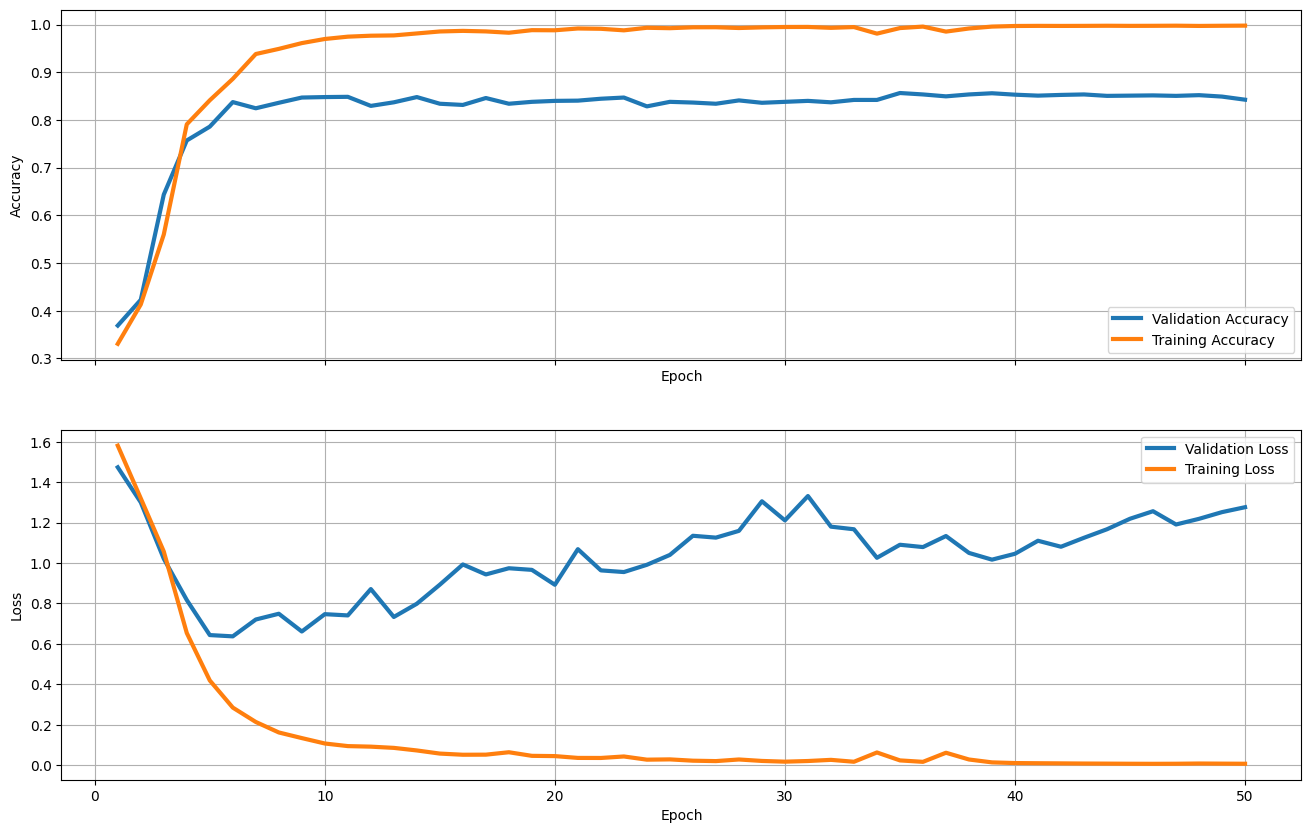

In [18]:
plot_results(history2)

In [21]:
val_sequences = tokenizer.texts_to_sequences(test_text)
val_padded = pad_sequences(val_sequences, maxlen=max_length, padding='post')

63/63 [==============================] - 2s 32ms/step
Accuracy: 0.0915
Precision: 0.0426
Recall: 0.0915
F1 Score: 0.0421


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


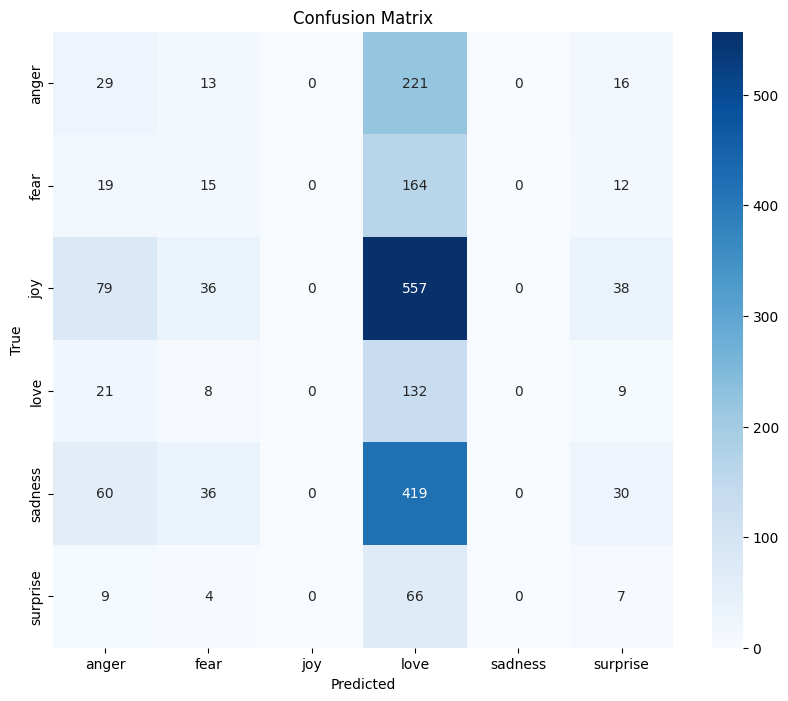

In [22]:
evaluate_model(model2, val_padded, y_val)

Clear Overfitting

#### LSTM Model

In [23]:
model3 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model3.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

history3 = model3.fit(train_padded, y_train, epochs=num_epochs, validation_data=(test_padded, y_val))


Epoch 1/50
250/250 [==============================] - 53s 202ms/step - loss: 1.6686 - accuracy: 0.3240 - val_loss: 1.5026 - val_accuracy: 0.4565
Epoch 2/50
250/250 [==============================] - 44s 175ms/step - loss: 1.1449 - accuracy: 0.5930 - val_loss: 1.0282 - val_accuracy: 0.6325
Epoch 3/50
250/250 [==============================] - 41s 165ms/step - loss: 0.7352 - accuracy: 0.7290 - val_loss: 0.8348 - val_accuracy: 0.7065
Epoch 4/50
250/250 [==============================] - 41s 166ms/step - loss: 0.4762 - accuracy: 0.8344 - val_loss: 0.7880 - val_accuracy: 0.7485
Epoch 5/50
250/250 [==============================] - 42s 167ms/step - loss: 0.3081 - accuracy: 0.9018 - val_loss: 0.7427 - val_accuracy: 0.7650
Epoch 6/50
250/250 [==============================] - 41s 164ms/step - loss: 0.2321 - accuracy: 0.9197 - val_loss: 0.7808 - val_accuracy: 0.7765
Epoch 7/50
250/250 [==============================] - 43s 170ms/step - loss: 0.1819 - accuracy: 0.9348 - val_loss: 0.7679 - val_ac

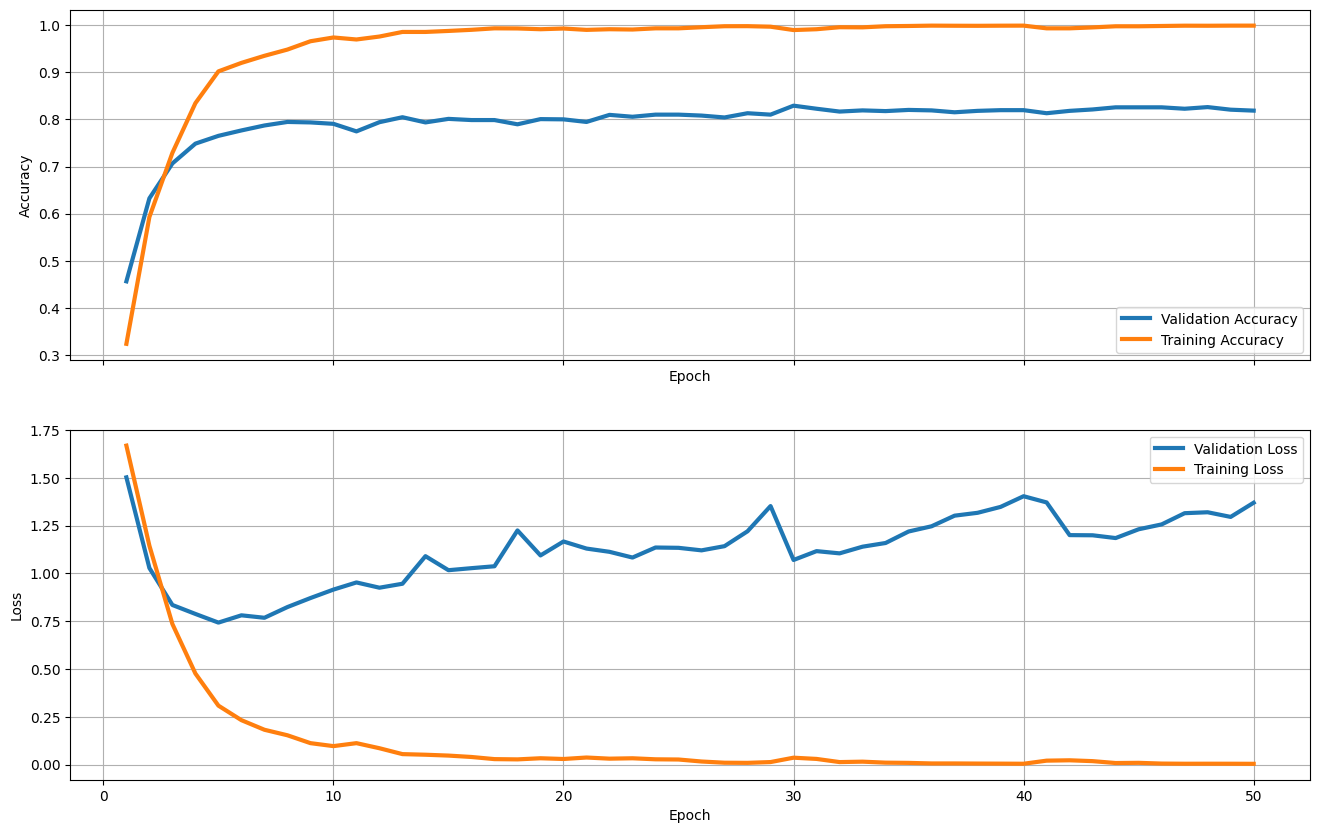

In [24]:
plot_results(history3)

63/63 [==============================] - 2s 28ms/step
Accuracy: 0.3550
Precision: 0.1260
Recall: 0.3550
F1 Score: 0.1860


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


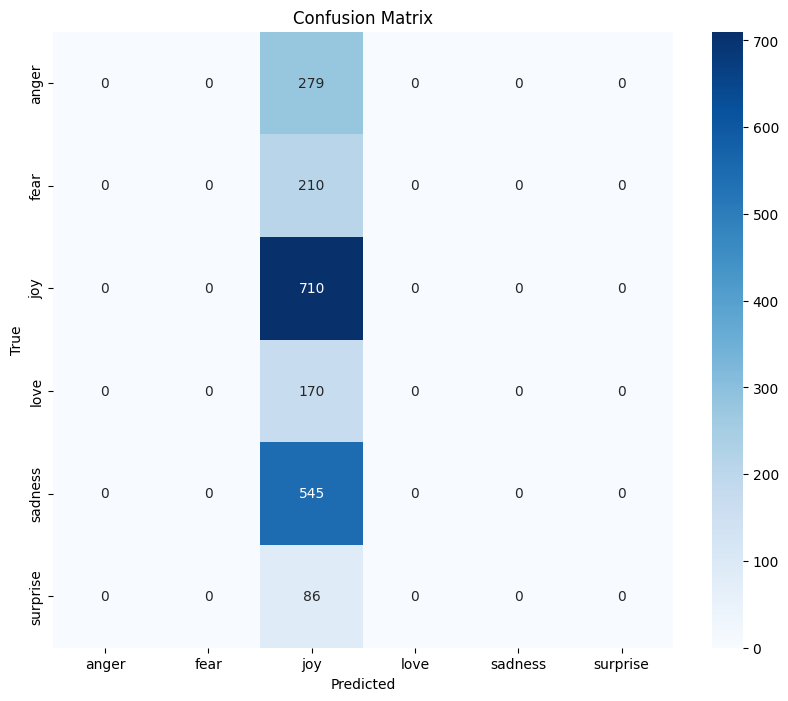

In [25]:
evaluate_model(model3, val_padded, y_val)

# Fine-Tuned Transformer Architecture

In [26]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model_transformer = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(np.unique(train_labels)))

# Tokenize the data
train_encodings = tokenizer(X_train.tolist(), truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(X_val.tolist(), truncation=True, padding=True, max_length=128)

# Convert to tf.data.Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    to_categorical(y_train)
)).shuffle(100).batch(32)

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    to_categorical(y_val)
)).batch(32)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [27]:
model_transformer.compile(optimizer='adam',
                          loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                          metrics=['accuracy'])

history4 = model_transformer.fit(train_dataset, epochs=num_epochs, validation_data=test_dataset)

Epoch 1/50
Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
250/250 [==============================] - 195s 409ms/step - loss: 1.6552 - accuracy: 0.3144 - val_loss: 1.6245 - val_accuracy: 0.2725
Epoch 2/50
250/250 [==============================] - 88s 353ms/step - loss: 1.6331 - accuracy: 0.3151 - val_loss: 1.6363 - val_accuracy: 0.2725
Epoch 3/50
250/250 [==============================] - 88s 353ms/step - loss: 1.6483 - accuracy: 0.3063 - val_loss: 1.6047 - val_accuracy: 0.3550
Epoch 4/50
250/250 [==============================] - 88s 353ms/step - loss: 1.6414 - accuracy: 0.3100 - val_loss: 1.6042 - val_accuracy: 0.3550
Epoch 5/50
250/250 [==============================] - 88s 353ms/step - loss: 1.6283 - accuracy: 0.3091 - val_loss: 1.6091 - val_accuracy: 0.2725
Epoch 6/50
250/250 [==============================] - 88s 353ms/step - loss: 1.6202 - accuracy: 0.3171 - val_loss: 1.5870 - val_accuracy

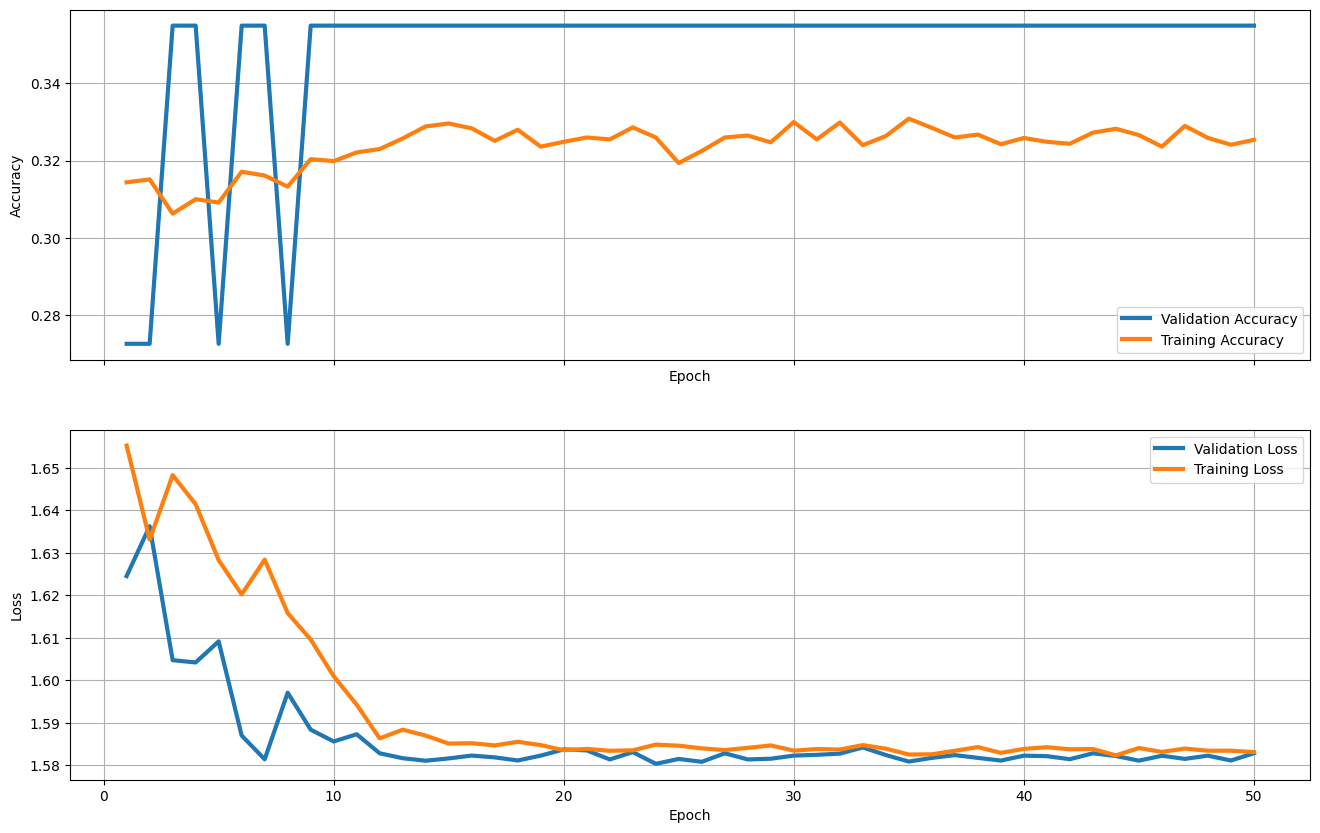

In [28]:
plot_results(history4)

In [38]:
val_encodings = tokenizer(X_val.tolist(), truncation=True, padding=True, max_length=128)
val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    y_val
)).batch(32)

def evaluate_model_transformer(model, test_dataset, y_test):
    y_pred_logits = model.predict(test_dataset).logits
    y_pred_classes = np.argmax(y_pred_logits, axis=1)
    
    accuracy = accuracy_score(y_test, y_pred_classes)
    precision = precision_score(y_test, y_pred_classes, average='weighted')
    recall = recall_score(y_test, y_pred_classes, average='weighted')
    f1 = f1_score(y_test, y_pred_classes, average='weighted')
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    plot_confusion_matrix(y_test, y_pred_classes, classes=le.classes_)


63/63 [==============================] - 8s 126ms/step
Accuracy: 0.3550
Precision: 0.1260
Recall: 0.3550
F1 Score: 0.1860


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


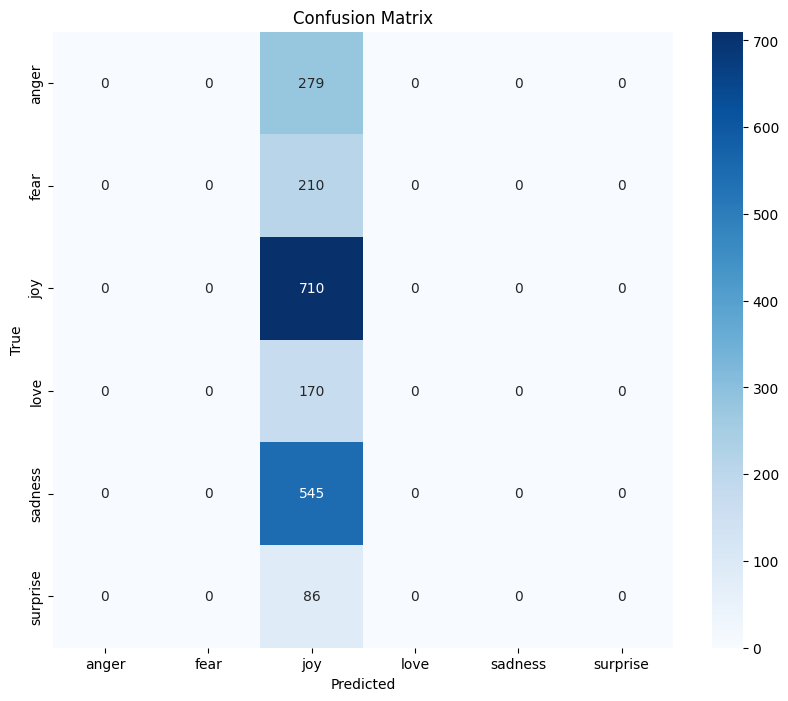

In [39]:
evaluate_model_transformer(model_transformer, val_dataset, y_val)

# Comparing Models:

The CNN done first achieved the best accuracy sue to regularization nd early drop to mitigte overfitting

